In [3]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [4]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [5]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [132]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [9]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...


In [16]:
print(train_data.iloc[0:2, [0, 1, 2, 3, -2, -1]])
print(test_data.iloc[0:2, [0, 1, 2, 3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleCondition  SalePrice
0   1          60       RL         65.0        Normal     208500
1   2          20       RL         80.0        Normal     181500
     Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition
0  1461          20       RH         80.0       WD        Normal
1  1462          20       RL         81.0       WD        Normal


In [22]:
# ID对于预测没有意义，直接剔除掉
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

### 数据预处理

In [143]:
numerical_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numerical_features] = all_features[numerical_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numerical_features] = all_features[numerical_features].fillna(0)

In [144]:
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features)

      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       0.067320    -0.184443 -0.217841     0.646073    -0.507197   1.046078   
1      -0.873466     0.458096 -0.072032    -0.063174     2.187904   0.154737   
2       0.067320    -0.055935  0.137173     0.646073    -0.507197   0.980053   
3       0.302516    -0.398622 -0.078371     0.646073    -0.507197  -1.859033   
4       0.067320     0.629439  0.518814     1.355319    -0.507197   0.947040   
...          ...          ...       ...          ...          ...        ...   
1454    2.419286    -2.069222 -1.043758    -1.481667     1.289537  -0.043338   
1455    2.419286    -2.069222 -1.049083    -1.481667    -0.507197  -0.043338   
1456   -0.873466     3.884968  1.246594    -0.772420     1.289537  -0.373465   
1457    0.655311    -0.312950  0.034599    -0.772420    -0.507197   0.682939   
1458    0.067320     0.201080 -0.068608     0.646073    -0.507197   0.715952   

      YearRemodAdd  MasVnrArea  BsmtFin

In [158]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
                            dtype=torch.float32)

In [161]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32
)

### 训练

In [119]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [154]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    #print(torch.min(clipped_preds))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [126]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    print(train_features.shape)
    print(train_labels.shape)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [127]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [128]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        print(valid_ls)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse {float(train_ls[-1]):f}, '
              f'验证log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

torch.Size([292, 331])
torch.Size([1168, 331])
torch.Size([1168, 1])
[8.8970308303833, 8.712395668029785, 8.614094734191895, 8.567347526550293, 8.506796836853027, 8.471829414367676, 8.435508728027344, 8.410381317138672, 8.397400856018066, 8.385543823242188]
折1，训练log rmse 8.423121, 验证log rmse 8.385544
torch.Size([292, 331])
torch.Size([1168, 331])
torch.Size([1168, 1])
[8.992897987365723, 8.826908111572266, 8.761841773986816, 8.711141586303711, 8.65774154663086, 8.632948875427246, 8.609143257141113, 8.590075492858887, 8.57555103302002, 8.563992500305176]
折2，训练log rmse 8.297028, 验证log rmse 8.563993
torch.Size([292, 331])
torch.Size([1168, 331])
torch.Size([1168, 1])
[8.944286346435547, 8.850706100463867, 8.731762886047363, 8.64871597290039, 8.620742797851562, 8.615693092346191, 8.567381858825684, 8.550919532775879, 8.54212474822998, 8.544048309326172]
折3，训练log rmse 8.353733, 验证log rmse 8.544048
torch.Size([292, 331])
torch.Size([1168, 331])
torch.Size([1168, 1])
[8.986340522766113, 8.813

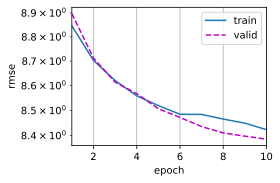

In [155]:
k, num_epochs, lr, weight_decay, batch_size = 5, 10, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse:  {float(train_l):f}, '
      f'平均验证log rmse:  {float(valid_l):f}')